## Signature verification using Siamese Network -

- Siamese network is a class of network architectures, that usually contains two identical subnetworks. The twin CNNs have the same configuration and shared weights. 

- These subnetworks are joined by a loss function at the top, which computes a similarity metric involving the Euclidean distance between the feature representation on each side of the Siamese network. One such loss function that is mostly used in Siamese network is the 'contrastive loss' used in this implementation.

- For a functioning system, a writer dependent system needs to be updated (retrained) with every new writer (signer). For a consumer based system, such as bank, where every day new consumers can open their account this incurs huge cost. Whereas, in writer independent case, a generic system is built to model the discrepancy among the genuine and forged signatures.

- For a particular signer, signatures are coupled as similar (genuine, genuine) or dissimilar (genuine, forged) pairs.

> For complete reference - https://arxiv.org/pdf/1707.02131.pdf

> Siamese network - https://github.com/keras-team/keras/blob/master/examples/mnist_siamese.py

In [1]:
import sys
import pickle
import os
import time
import itertools
import random

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from sklearn.utils import shuffle

import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

from keras.models import Sequential
from keras.optimizers import Adam, RMSprop
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Dropout
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.engine.topology import Layer
from keras.regularizers import l2
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

Using TensorFlow backend.


In [2]:
# data directory
path = "./data/BHSig260/Hindi/"

# get the list of all directories and sort them
dir_list = next(os.walk(path))[1]
dir_list.sort()

# Seperate the genuine and forged signatures
orig_groups, forg_groups = [], []

# iterate over all the directories
for directory in dir_list:
    
    # get all the image directories and sort them as well
    images = os.listdir(path+directory)
    images.sort()
    
    # get the image_paths for individual images and store them
    images = [path+directory+'/'+x for x in images]
    
    # append first 30 images to forged list
    forg_groups.append(images[:30])
    
    # append the remaining i.e. last 24 or images from 30 onwards to original list
    orig_groups.append(images[30:])
    
# print to check the size now
print(f"original - {len(orig_groups)}, Forged - {len(forg_groups)}")

original - 160, Forged - 160


In [3]:
# Train, test split
orig_train, orig_val, orig_test = orig_groups[:120], orig_groups[120:140], orig_groups[140:]
forg_train, forg_val, forg_test = forg_groups[:120], forg_groups[120:140], forg_groups[140:]

In [4]:
# All the images will be converted to the same size before processing
img_h, img_w = 155, 220

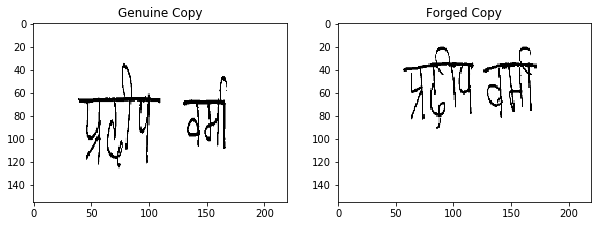

In [5]:
# function that will visualize a random sample (original, forged)
def visualize_sample_signature():
    
    # using subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))
    
    # pick a random number
    k = np.random.randint(len(orig_train))
    
    # original image
    orig_img_name = random.sample(orig_train[k], 1)
    
    # forged image
    forg_img_name = random.sample(forg_train[k], 1)
    
    # read the original and forged images
    orig_img = cv2.imread(orig_img_name[0], 0)
    forg_img = plt.imread(forg_img_name[0], 0)
    
    # resize the images to be of the specified shape
    orig_img = cv2.resize(orig_img, (img_w, img_h))
    forg_img = cv2.resize(forg_img, (img_w, img_h))

    # plot the images
    ax1.imshow(orig_img, cmap = 'gray')
    ax2.imshow(forg_img, cmap = 'gray')
    
    # label them
    ax1.set_title('Genuine Copy')
    ax2.set_title('Forged Copy')
    
visualize_sample_signature()

In [6]:
def generate_batch(orig_groups, forg_groups, batch_size = 32):
    '''
    params: original, forged sets, batch_size(default = 32)
    output: pairs, targets
    '''
    while True:
        orig_pairs = []
        forg_pairs = []
        gen_gen_labels = []
        gen_for_labels = []
        all_pairs = []
        all_labels = []
        
        # iterate over and add pairs(original,original) and (original_forged) to resp. lists
        for orig, forg in zip(orig_groups, forg_groups):
            
            # 24 genuine signatures for each of the authors, there are only 24C2 = 276 (genuine, genuine) signature pairs
            orig_pairs.extend(list(itertools.combinations(orig, 2)))
            
            # iterate over the forged images
            for i in range(len(forg)):
                
                # To make Genuine-Forged pairs, we pair every Genuine signature of a person with 12 randomly sampled Forged signatures of the same person.
                forg_pairs.extend(list(itertools.product(orig[i:i+1], random.sample(forg, 12))))
        
        # labels - (genuine,genuine) = 1, (genuine, forged)=0
        gen_gen_labels = [1]*len(orig_pairs)
        gen_for_labels = [0]*len(forg_pairs)
        
        # Concatenate all the pairs together along with their labels and shuffle them
        all_pairs = orig_pairs + forg_pairs
        all_labels = gen_gen_labels + gen_for_labels
        all_pairs, all_labels = shuffle(all_pairs, all_labels)
        
        # counter to keep a count of the batch size    
        k = 0
        
        # the pairs and targets lists that will be returned
        pairs=[np.zeros((batch_size, img_h, img_w, 1)) for i in range(2)]
        targets=np.zeros((batch_size,))
        
        # iterate over all pairs
        for ix, pair in enumerate(all_pairs):
            
            # invert images so that the background pixels have 0 values
            img1 = cv2.imread(pair[0], 0)
            img2 = cv2.imread(pair[1], 0)
            
            # resize images to the specified shape
            img1 = cv2.resize(img1, (img_w, img_h))
            img2 = cv2.resize(img2, (img_w, img_h))
            
            # convert images to numpy array with datatype 'float'
            img1 = np.array(img1, dtype = np.float64)
            img2 = np.array(img2, dtype = np.float64)
            
            # normalize the images
            img1 /= 255
            img2 /= 255
            
            # equivalent to x[:,:,np.newaxis]
            img1 = img1[..., np.newaxis]
            img2 = img2[..., np.newaxis]
            
            
            pairs[0][k, :, :, :] = img1
            pairs[1][k, :, :, :] = img2
            
            targets[k] = all_labels[ix]
            
            k += 1
            if k == batch_size:
                yield pairs, targets
                k = 0
                pairs=[np.zeros((batch_size, img_h, img_w, 1)) for i in range(2)]
                targets=np.zeros((batch_size,))

In [7]:
# helper functions

def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def contrastive_loss(y_true, y_pred):
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

In [8]:
def create_base_network_signet(input_shape):
    '''Base Siamese Network'''
    
    seq = Sequential()
    seq.add(Conv2D(96, kernel_size=(11, 11), activation='relu', name='conv1_1', strides=4, input_shape= input_shape, 
                        init='glorot_uniform', dim_ordering='tf'))
    seq.add(BatchNormalization(epsilon=1e-06, mode=0, axis=1, momentum=0.9))
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))    
    seq.add(ZeroPadding2D((2, 2), dim_ordering='tf'))
    
    seq.add(Conv2D(256, kernel_size=(5, 5), activation='relu', name='conv2_1', strides=1, init='glorot_uniform',  dim_ordering='tf'))
    seq.add(BatchNormalization(epsilon=1e-06, mode=0, axis=1, momentum=0.9))
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))
    seq.add(Dropout(0.3))# added extra
    seq.add(ZeroPadding2D((1, 1), dim_ordering='tf'))
    
    seq.add(Conv2D(384, kernel_size=(3, 3), activation='relu', name='conv3_1', strides=1, init='glorot_uniform',  dim_ordering='tf'))
    seq.add(ZeroPadding2D((1, 1), dim_ordering='tf'))
    
    seq.add(Conv2D(256, kernel_size=(3, 3), activation='relu', name='conv3_2', strides=1, init='glorot_uniform', dim_ordering='tf'))    
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))
    seq.add(Dropout(0.3))# added extra
    seq.add(Flatten(name='flatten'))
    seq.add(Dense(1024, W_regularizer=l2(0.0005), activation='relu', init='glorot_uniform'))
    seq.add(Dropout(0.5))
    
    seq.add(Dense(128, W_regularizer=l2(0.0005), activation='relu', init='glorot_uniform')) # softmax changed to relu
    
    return seq

In [9]:
# Shape of input image
input_shape=(img_h, img_w, 1)

# network definition
base_network = create_base_network_signet(input_shape)

# input layers
input_a = Input(shape=(input_shape))
input_b = Input(shape=(input_shape))

# Re-use the same instance 'base_network'
processed_a = base_network(input_a)
processed_b = base_network(input_b)

# Euclidean distance between the two processed vectors
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])

# initialise our model with input and output
model = Model(input=[input_a, input_b], output=distance)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [10]:
# some global variables
batch_sz = 24
num_train_samples = 276*120 + 300*120
num_val_samples = num_test_samples = 276*20 + 300*20
print(f"num_train_samples: {num_train_samples}, num_val_samples: {num_val_samples}, num_test_samples: {num_test_samples}")

num_train_samples: 69120, num_val_samples: 11520, num_test_samples: 11520


In [11]:
# compile model using RMSProp Optimizer and contrastive loss function
rms = RMSprop(lr=1e-4, rho=0.9, epsilon=1e-08)
model.compile(loss=contrastive_loss, optimizer=rms)

# keras callbacks
callbacks = [
    
    # save the model after every epoch
    EarlyStopping(patience=12, verbose=1),
    
    # Reduce the learning rate by a factor of 0.1 if the validation loss does not improve for 5 epochs
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    
    # Stop the training using early stopping if the validation loss does not improve for 12 epochs
    ModelCheckpoint('./model/siamese_net_bhsig260-{epoch:02d}.h5', verbose=1, save_weights_only=True)
]

In [12]:
# train the model
results = model.fit_generator(generate_batch(orig_train, forg_train, batch_sz),
                              steps_per_epoch = num_train_samples//batch_sz,
                              epochs = 2,
                              validation_data = generate_batch(orig_val, forg_val, batch_sz),
                              validation_steps = num_val_samples//batch_sz,
                              callbacks = callbacks)

Instructions for updating:
Use tf.cast instead.
Epoch 1/2
2880/2880 [==============================] - 1779s 618ms/step - loss: 0.4024 - val_loss: 0.1367

Epoch 00001: saving model to ./model/siamese_net_bhsig260-01.h5
Epoch 2/2
2880/2880 [==============================] - 1728s 600ms/step - loss: 0.0626 - val_loss: 0.1373

Epoch 00002: saving model to ./model/siamese_net_bhsig260-02.h5


In [13]:
def compute_accuracy_roc(predictions, labels):
    '''
    params: predictions, labels
    output: maximum accuracy and best threshold
    '''
    dmax = np.max(predictions)
    dmin = np.min(predictions)
    nsame = np.sum(labels == 1)
    ndiff = np.sum(labels == 0)
   
    step = 0.01
    max_acc = 0
    best_thresh = -1
   
    for d in np.arange(dmin, dmax+step, step):
        idx1 = predictions.ravel() <= d
        idx2 = predictions.ravel() > d
        
        # Total positive and negative rate
        tpr = float(np.sum(labels[idx1] == 1)) / nsame       
        tnr = float(np.sum(labels[idx2] == 0)) / ndiff
        
        # accuracy
        acc = 0.5 * (tpr + tnr)       
        
        # update max
        if (acc > max_acc):
            max_acc, best_thresh = acc, d
    
    # return the accuracy and threshold values
    return max_acc, best_thresh

In [14]:
# load weights
model.load_weights('./model/siamese_net_bhsig260-02.h5')

In [15]:
# predict on test set
test_gen = generate_batch(orig_test, forg_test, 1)

# the predicted and true labels
pred, tr_y = [], []

# iterate over the training set
for i in range(num_test_samples):
    
    (img1, img2), label = next(test_gen)
    
    # append true label to tr_y
    tr_y.append(label)
    
    # append prediction to pred
    pred.append(model.predict([img1, img2])[0][0])

# compute accuracy and threshold
tr_acc, threshold = compute_accuracy_roc(np.array(pred), np.array(tr_y))
tr_acc, threshold

(0.8164631683018069, 0.5900045650358515)

#### Accuracy = 81.46% and Threshold = 0.59

>      Difference < 0.59 - genuine
>      Difference > 0.59 - forged

In [18]:
def predict_score():
    '''
    Calculate the distance score and return 'Genuine' or 'Forged' acc to the threshold values
    '''
    test_point, test_label = next(test_gen)
    img1, img2 = test_point[0], test_point[1]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))
    ax1.imshow(np.squeeze(img1), cmap='gray')
    ax2.imshow(np.squeeze(img2), cmap='gray')
    ax1.set_title('Genuine')
    if test_label == 1:
        ax2.set_title('Genuine')
    else:
        ax2.set_title('Forged')
    plt.show()
    result = model.predict([img1, img2])
    diff = result[0][0]
    print("Difference Score = ", diff)
    if diff > threshold:
        print("Forged Signature")
    else:
        print("Genuine Signature")

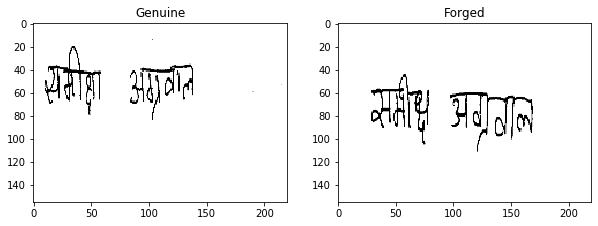

Difference Score =  1.397328
Forged Signature


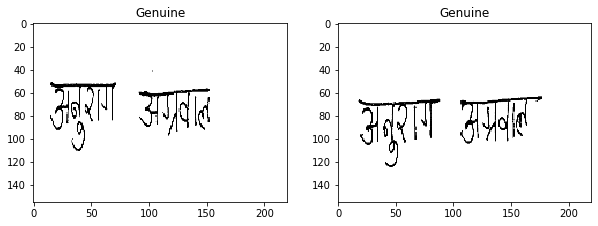

Difference Score =  0.16206072
Genuine Signature


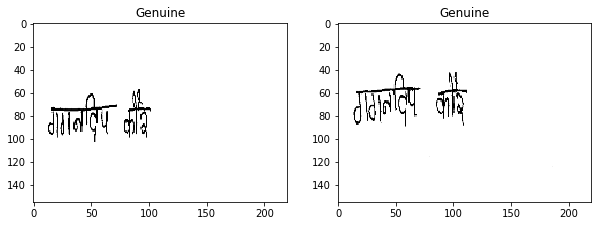

Difference Score =  0.13686056
Genuine Signature


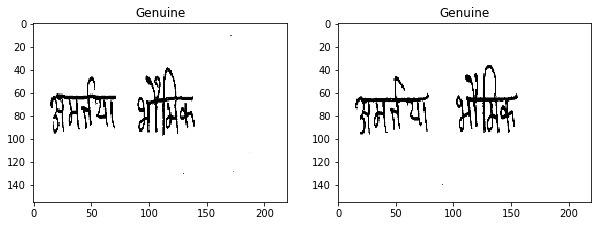

Difference Score =  0.021039236
Genuine Signature


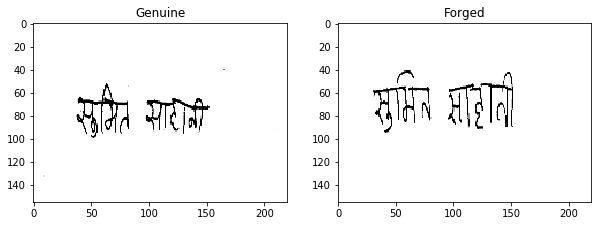

Difference Score =  0.76249844
Forged Signature


In [21]:
# check 5 results
for i in range(5):
    predict_score()